<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/homeworks/base/GenDL_HT4_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 4 (base): авторегрессионные модели и мультимодальность

В этом домашнем задании вам предлагается обучить авторегрессионную модель для генерации изображений (PixelCNN), а также сделать подход мультимодальным,  обусловив модель на CLIP-эмбеддинги.

# Рекомендации (sanity check) по обучению модели

1) Обучите вашу модель на выборке из 100 картинок (первые 100 из датасета) + всех возможных кепшенов для них. Модель должна переобучится под эти 100 картинки и выдавать очень низкий bpd и генерить хорошие картинки. Это санити чек для задачи 4 и 5. Оставьте этот ран в ноутбуке, чтобы мы тоже видели (постарайтесь сделать это красиво, не копипастя все клетки ноутбука, а именно конфигурируя эксперимент)

2) Идем на весь датасет, чтобы научиться обобщаться на разные картинки и промпты. Хорошая в рамках дз модель должна научится как минимум рисовать background-ы и иногда показывать очертания птиц. Чтобы птицы (или что-то на них похожее) стали более видны (и cond и uncond), используйте температуру при сэмплировании (подумайте почему это влияет). Будет заметно влиятнее промпта

В задаче можно точно выбить bpd в 8.9 — как ориентир после долгого обучения. 9.8 должно выбиваться довольно быстро.

### Задание 1 (0 баллов)

Скачайте [датасет про птиц с HuggingFace](https://huggingface.co/datasets/weiywang/CUB_200_2011_CAP).

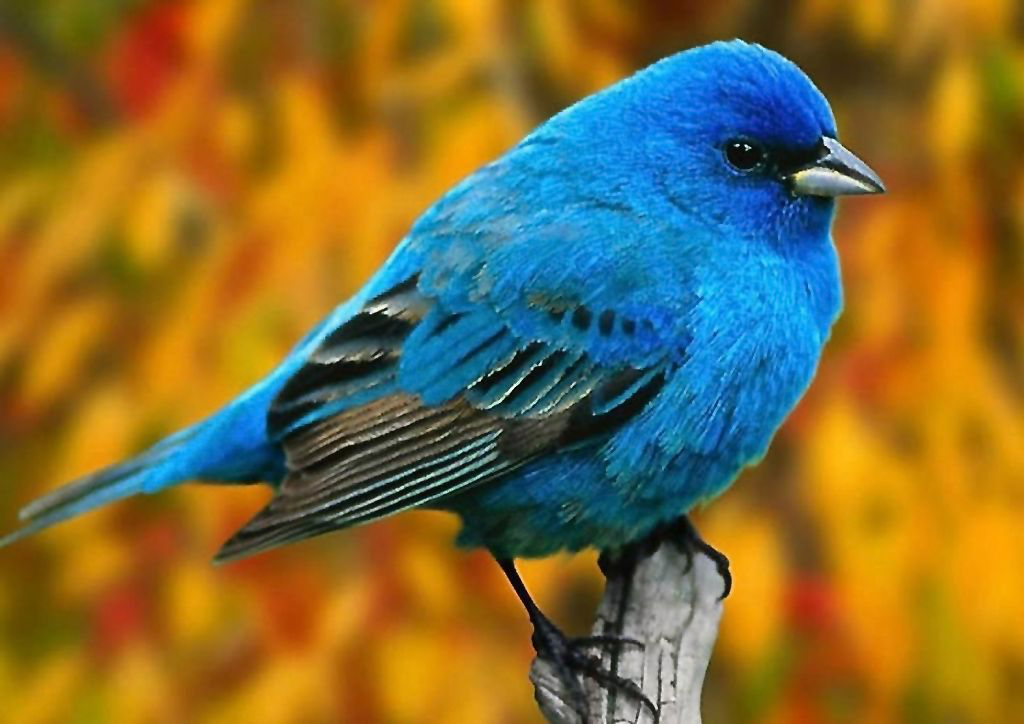

In [ ]:
# ваш код здесь

### UPD: VQ-VAE

VQ-VAE - это автоэнкодер, который позволяет сжимать большие входные изображения в дискретное латентное пространство (последовательность кодов) и декодировать их обратно (см. рис).

<img src="https://substackcdn.com/image/fetch/$s_!dRiM!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F81630fcc-b23e-4f06-831f-690aff70e03b_1215x476.png" width="800" height="400">

VQ-VAE состоит из трех частей. Энкодер кодирует входное изображение $x \in \mathbb{R}^{B \times C \times H \times W}$ в непрерывное латентное пространство $z_e \in \mathbb{R}^{B \times D \times H_{h} \times W_{h}}$. Quantizer смотрит на каждый вектор из $z_e$ ($H_{h} \times W_{h}$ штук длины $D$) и заменяет их на ближайший похожий вектор из словаря-векторов (codebook), который обучался вместе с моделью. Сам $z_e$после такой операции заменяется на $z_q$ (те же размеры, но каждый вектор заменен на ближайшего из кодбука). $z_q$ можно хранить либо как непрерывный тензор $\mathbb{R}^{B \times D \times H_{h} \times W_{h}}$, либо просто хранить $B \times  H_{h} \times W_{h}$ дискретных индексов из кодбука, где индексы соответствуют номеру вектора в кодбуке (для примера, если у нас 4096 векторов в кодбуке и мы $z_e$ заменили на вектора на местах $1, 2000, 2, 10$ из кодбука, то теперь $z_q$ в дискретном виде это просто массив $1, 200, 2, 10$). Декодер, последняя часть VQ-VAE, берет $z_q$ и переводит из кодов обратно в вектора из кодбука (если $z_q$ был в виде кодов, а не векторов) и прогоняет $z_q$ через набор слоев, чтобы получить изображение $\hat{x} \simeq x$.


$H_{h} \times W_{h}$ как правило сильно меньше оригинальных $H \times W$, поэтому многие генеративные модели используют VQ-VAE для генерации высококачественных изображений без значительного усложнения вычислительной сложности. Действительно, если вместо авторегрессионной генерации $С \times H \times W$, где $H, W \ge 128$ мы будем работать с дискретным тензором $H_{h} \times W_{h}$, где $H_h, W_h \le 32$, то мы сможем генерировать качественные изображения с той же вычислительной сложностью как если бы сделали resize изначальных картинок в $32\times32$, но при этом не теряем в качестве изображений (ведь финальное изображение получается прогоном кодов через декодер).

Давайте посмотрим как это работает:

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Скачаем предобученную VQ-VAE

from diffusers import VQModel
vqvae = VQModel.from_pretrained("microsoft/vq-diffusion-ithq", subfolder="vqvae")
vqvae.to(device)

Скачаем картинку для примера

In [ ]:
!wget "https://upload.wikimedia.org/wikipedia/commons/1/16/Myophonus_caeruleus_-_Ang_Khang_edit1.jpg" -O example.jpg

--2025-11-16 11:34:08--  https://upload.wikimedia.org/wikipedia/commons/1/16/Myophonus_caeruleus_-_Ang_Khang_edit1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1474949 (1.4M) [image/jpeg]
Saving to: ‘example.jpg’

example.jpg         100%[===================>]   1.41M  --.-KB/s    in 0.06s   

2025-11-16 11:34:09 (24.9 MB/s) - ‘example.jpg’ saved [1474949/1474949]



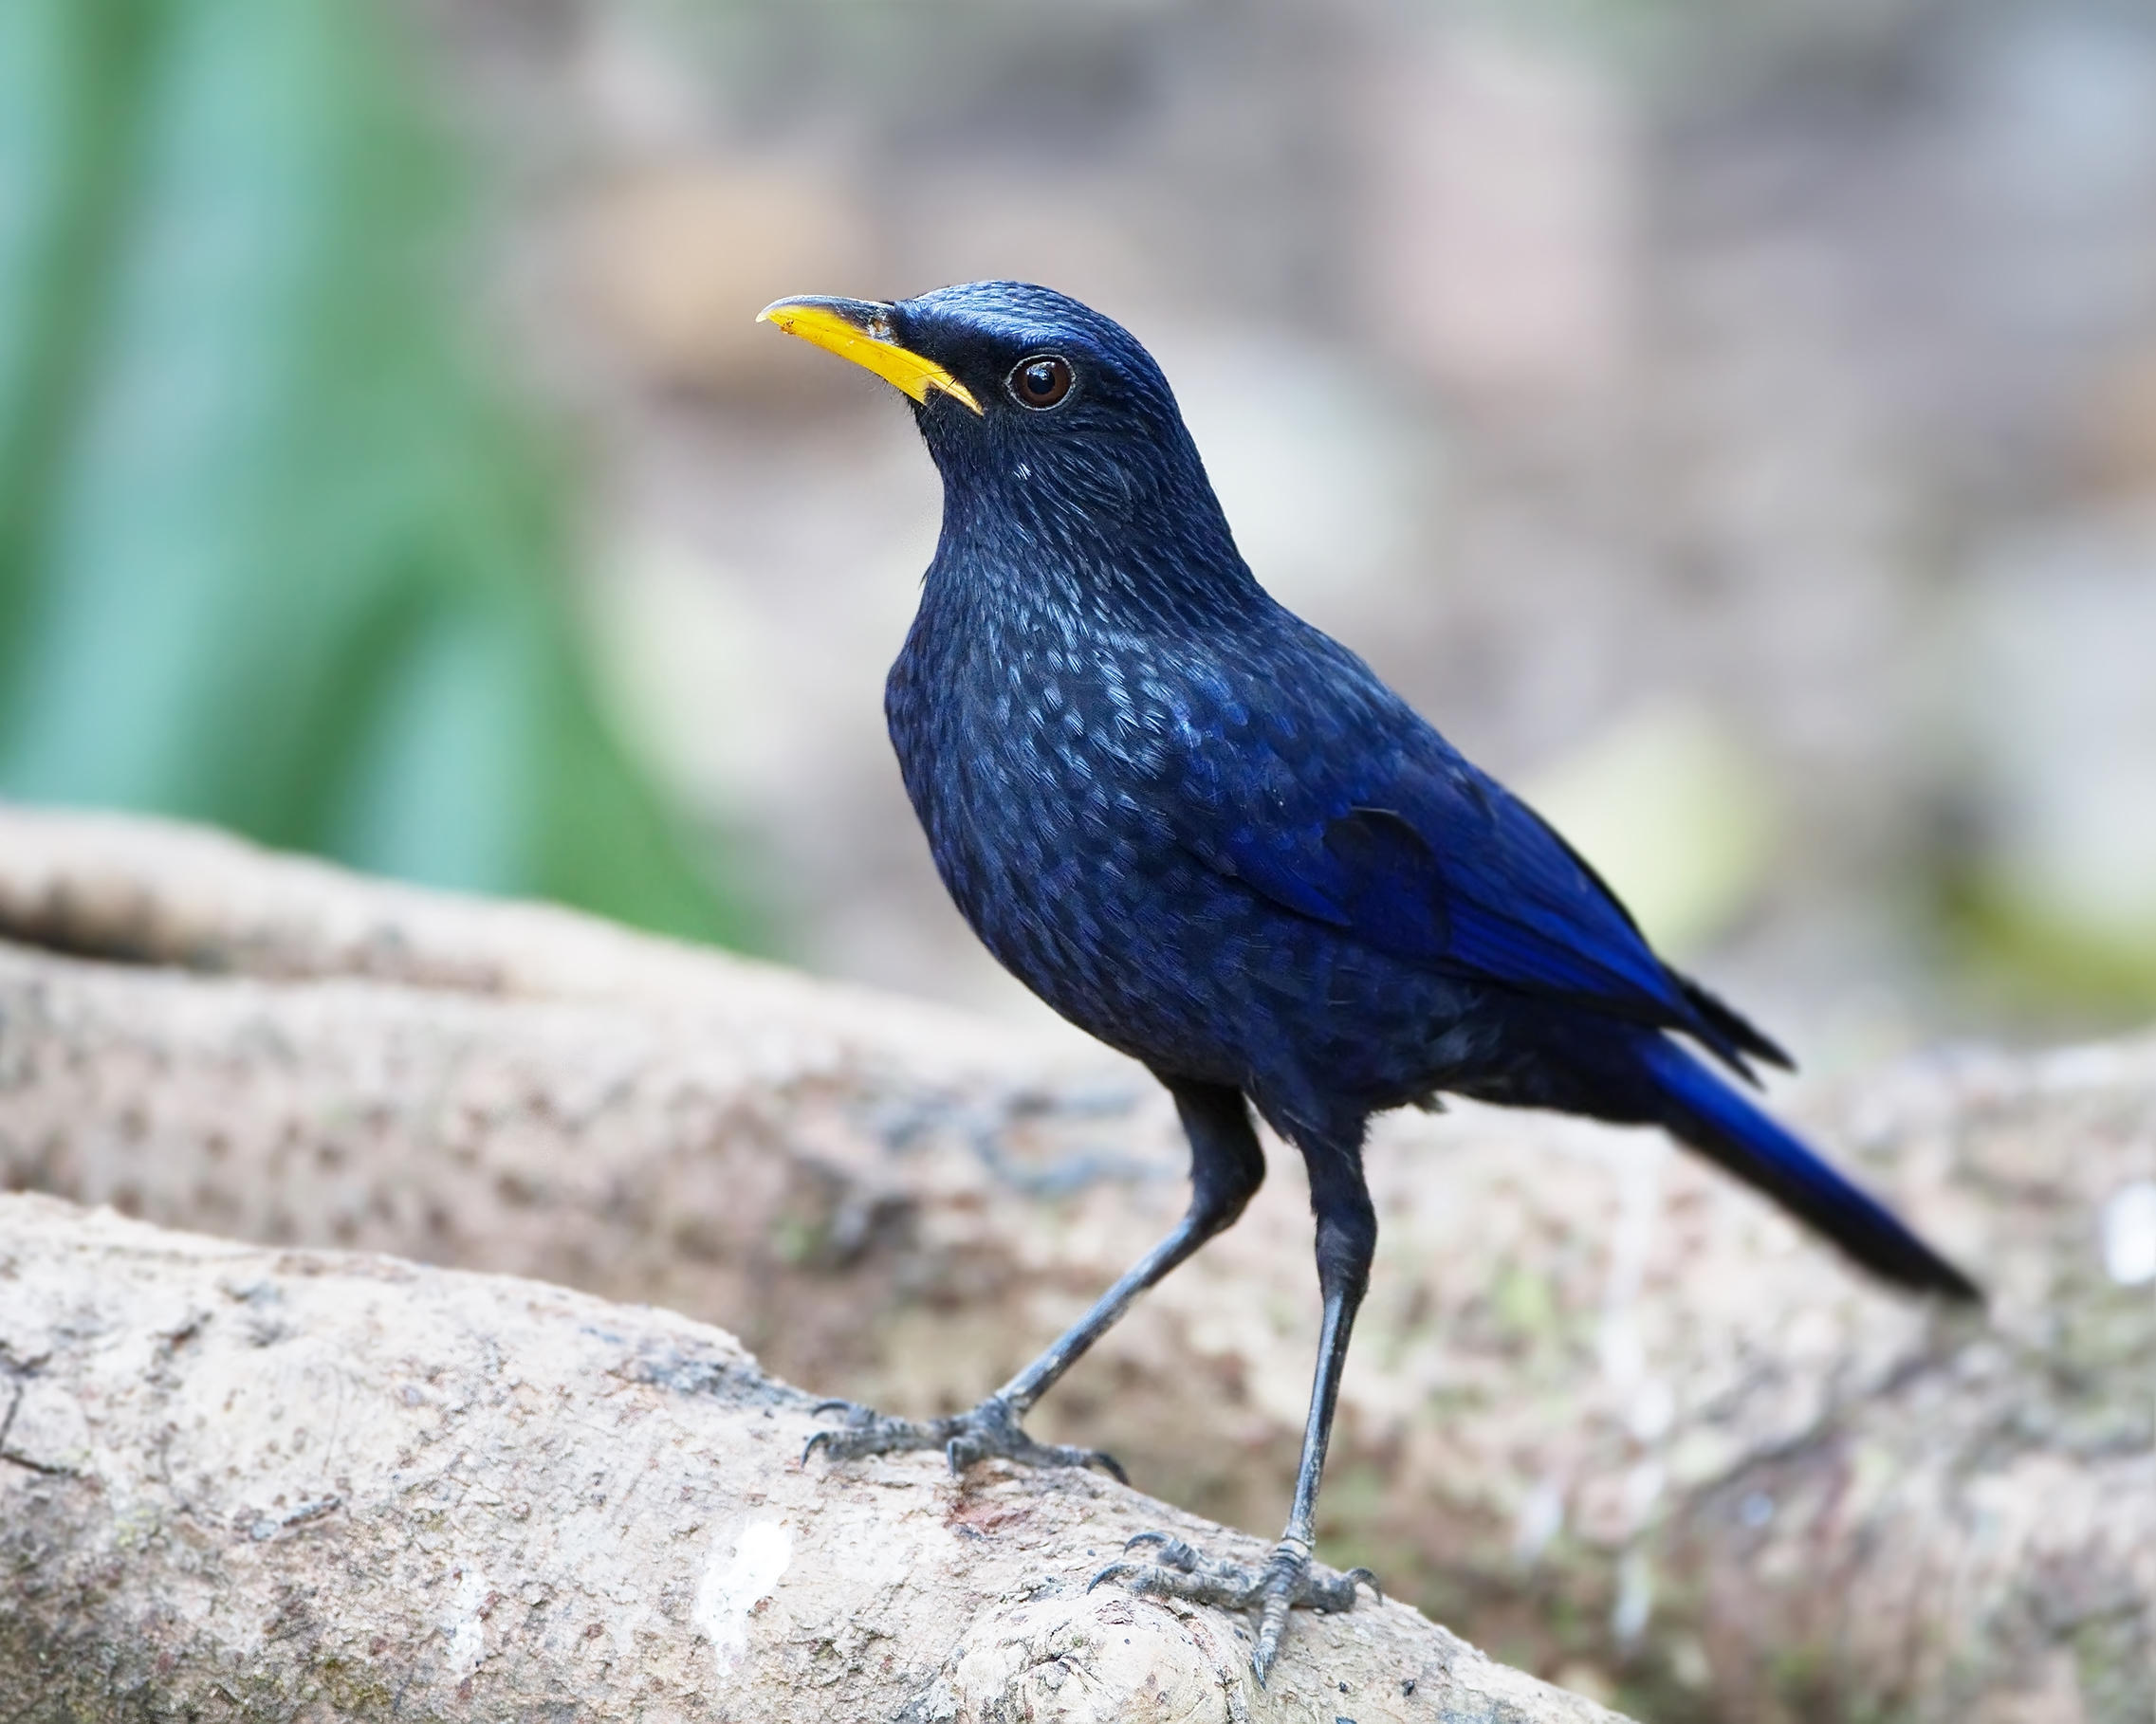

In [ ]:
from PIL import Image

img = Image.open("example.jpg")
img

VQ-VAE этот работает на изображениях $256\times 256$, поэтому ресайзим

In [ ]:
from torchvision import transforms

x = transforms.Resize((256, 256))(img)
x = transforms.ToTensor()(x)
x.shape

torch.Size([3, 256, 256])

Код для получения кодов и декодирования изображения:

In [ ]:
def img_to_codes(x, vqvae):
    if x.ndim != 4:
        x = x.unsqueeze(0)
    # для нормализации вход не [0, 1], а [-1, 1]
    x = x * 2 - 1
    # применяем энкодер
    latent = vqvae.encode(x).latents
    # получаем z_q и соответствующие коды
    quant, commit_loss, (_, _, indices) = vqvae.quantize(latent)
    # коды тут flatten, решейпим обратно
    B, _, Hc, Wc = latent.shape
    if indices.dim() == 1:
        codes = indices.view(B, Hc, Wc)
    else:
        codes = indices
    return codes

def codes_to_img(codes, vqvae):
    B, Hc, Wc = codes.shape
    codes = codes.view(-1)
    # получаем непрерывное z_q из соответствующих кодов,
    # смотря на вектора из кодбука по индексам
    quant = vqvae.quantize.get_codebook_entry(
        codes,
        shape=(B, Hc, Wc, vqvae.quantize.vq_embed_dim)  # (B, H, W, C)
    )
    # декодируем
    quant2 = vqvae.post_quant_conv(quant)
    dec = vqvae.decoder(quant2, quant if vqvae.config.norm_type == "spatial" else None)
    return (dec + 1) / 2

Применим:

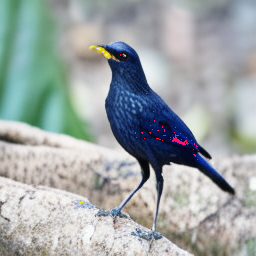

In [ ]:
codes = img_to_codes(x.to(device), vqvae)
hat_x = codes_to_img(codes, vqvae)
transforms.ToPILImage()(hat_x[0])

In [ ]:
codes

tensor([[[ 817, 2035, 1131,  ..., 2121, 3251,  308],
         [ 959, 3175, 3348,  ...,  798,  890,  626],
         [4008,  485, 1446,  ...,  300, 2945,  113],
         ...,
         [1287, 3999, 2154,  ..., 1070, 2207, 1166],
         [3132, 4010,  896,  ...,  729, 2359, 3617],
         [1282, 1434, 3435,  ...,  312,  109, 1547]]], device='cuda:0')

Видим, что у нас получилось довольно хорошо восстановить изображения из кодов. Но какие размеры у `codes`?

In [ ]:
codes.shape

torch.Size([1, 32, 32])

$B=1$, т.е. вместо $3\times 256\times 256$ (RGB) мы получаем всего лишь $32\times 32$.

Раньше, дискретных значений было в одном пикселе было $3 \cdot 256$ (цвета в RGB по каждому каналу). Теперь кол-во дискретных значения задается количеством кодов в кодбуке vqvae $N_q$

In [ ]:
vqvae.config.num_vq_embeddings

4096

Как и прежде, мы можем генерировать подобные дискретные тензоры авторегрессионно с помощью PixelCNN, но если раньше мы работали в пространстве изображений, то теперь будем работать в латентном. Как и раньше, мы будем считать, что $32\times32$ тензор это последовательность токенов со значениями из $[0, N_q-1]$, которую мы считываем построчно слево направо. Наш PixelCNN, как и раньше, будет смотреть только на предыдущие токены, чтобы генерировать новый. Модель каждый шаг будет предсказывать вероятностное распределение на словаре: $[0, N_q-1]$

То есть, все буквально, как и раньше, но вместо RGB изображений, мы будем генерировать `codes`. Чтобы получить RGB, мы просто прокинем codes через декодер VQ-VAE и получим RGB изображений в высоком разрешении.

P.S. Поскольку VQ-VAE сильно сжимает изображение, мы заодно избавляемся от высокочастотного шума, который присутствует в цветных натуральных изображениях и мешает авторегрессионным генераторам делать хорошую генерацию. В изначальной версии ДЗ PixelCNN могло получить хороший bpd, но генерировало RGB шум из-за слишком разнообразного фона на картинках птиц. VQ-VAE, засчет сжатия, делает каждый токен очень значимым (нет двух соседних токенов, которые по сути отвечают лишь за две соседние маленькие точки фона, мешая PixelCNN обучиться). Действительно, если изначально картинка была с стороной 256, а стала с 32 в  `codes`, то каждый токен отвечает за участок размера $8\times8$, что куда более значимо, чем один пиксель в исходном изображении. Можно было бы сказать, что такого же эффекта "значимости" можно было бы добиться просто resize в $32\times 32$ RGB картинки, но PixelCNN путался бы из-за цветов (3 канала в RGB, в `codes` нет каналов), а также сами пиксели имели бы лишь поверхностное значение. В VQ-VAE токены смоделированы специально для сжатия и восстановления обратно в $256\times 256$, поэтому каждый токен содержит в себе более глубокую и детальную информацию, чем просто resize-нутый пиксель.

### Задание 2 (1 балл).

Скачайте любую версию предобученного CLIP на ваш вкус, примените текстовый кодировщик к описаниям птиц из датасета (столбец "text") и сохраните получившиеся эмбеддинги.

Возьмите из датасета две картинки с визуально похожими птицами и посчитайте косинусную близость эмбеддингов подписей к этим фото, оцените корректность результата.

In [ ]:
# ваш код здесь

### Задание 3 (0.5 балла).

Соберите картинки и получившиеся эмбеддинги в датасеты. Сохраните два датасета: один только с изображениями, другой - с изображениями и эмбеддингами подписей.

- Сконвертируйте картинки в соответствующие `codes` (используйте функции выше)

Hint: внимательно посмотрите на кол-во каналов в изображениях датасета и размеры картинок, предобработайте картинки перед подачей в VQ-VAE

Hint 2: сначала используется сабсет из вашего датасета для дебага, потому что датасет конвертируется долго, после дебага используйте весь

In [ ]:
# ваш код здесь

### Задание 4 (2 балла).

- Обучите [модель из семинара (PixelCNN)](https://colab.research.google.com/drive/1EIsBxlTcz3ZB0j-ZxN1gWD2dSQq6krPj?usp=sharing) только на `codes` птиц. Модифицируйте размерности тензоров в модели, где это необходимо - чтобы она корректно работала с данными изображениями (обратите внимание на то, какие дискретные числа должны предсказывать ваша модель)

- Сделайте обучаемый `nn.Embedding` для `codes` перед подачей в слои свертки

- Вы можете менять гиперпараметры для улучшения качества генерации

- Выведите на экран 10 сгенерированных картинок, оцените результат, напишите выводы

Hint: добавьте конвертацию кодов в изображения в функцию отрисовки картинок, а не в `sample`.

In [ ]:
# ваш код здесь

### Задание 5 (3.5 балла).

- Добавьте сохраненные эмбеддинги подписей к архитектуре PixelCNN (это можно сделать любым способом - прибавить эмбеддинги, сконкатенировать их, использовать cross-attention или любой другой подход).

- Обучите такую conditional-модель на птицах и эмбеддингах текстов, выведите на экран по 10 промптам, похожим по формату на промпты из трейна, сгенерированные картинки. Оцените результат, напишите выводы (здесь вы тоже можете менять гиперпараметры модели)

**Hint:** для улучшения качества в последующих заданиях можете прочитать сначала условие задания 6

In [ ]:
 # ваш код здесь

### Задание 6 (0.5 балла).

Добавьте [classifier-free guidance](https://colab.research.google.com/drive/1EIsBxlTcz3ZB0j-ZxN1gWD2dSQq6krPj?usp=sharing) на этапе инференса для увеличения разнообразия генерации. Проведите несколько экспериментов.

Для улучшения качества и разнообразия генерации (опционально) можно добавить [classifier-free guidance и на этапе обучения](https://education.yandex.ru/handbook/ml/article/diffuzionnye-modeli):
- для этого во время обучения эмбеддинг промпта заменяется с какой-то фиксированной вероятностью (например, 10%) на эмбеддинг пустого промпта



In [ ]:
# ваш код здесь

### Задание 7 (0.5 балла)

Реализуйте какую-нибудь метрику качества генерации - на ваш выбор (это может быть Inception Score, Frechet Inception Distance, LPIPS или что-то другое). Вам необходимо привести работающий код для вычисления метрики и текстом пояснить как работает метрика.

Далее вычислите значение этой метрики для обученной в задании 5 модели и сделайте выводы.

In [ ]:
# ваш код здесь

### Задание 8 (0.5 балла).

Можете делать любые действия для улучшения работы вашей модели (менять число слоев, параметры архитектуры - не отходя от концепции PixelCNN, менять гиперпараметры, делать аугментацию изображений и текстов и так далее).

Проведите эксперименты по улучшению качества модели - оценивайте качество модели с точки зрения:
- Реализованной в задании 7 метрики
- Визуально.

Мы ожидаем, что качество может не вырасти, но и не упадет.

In [ ]:
# ваш код здесь

### Задание 9 (1.5 балла).

Проанализируйте лучшую модель:

- Придумайте 5 разных признаков (например, цвет, вид оперения, длина клюва, лап и так далее) и посмотрите, будет ли модель их понимать благодаря текстовому эмбеддингу? (0.5 балла)

- Попробуйте добавлять в модель другие промпты - не связанные с птицами, или по-другому построенные (не "a photo of", а по-другому сформулированные). Как отрабатывает модель? (0.5 балла)

- Фиксируйте удачный промпт и проведите эксперименты по изменению веса guidance в classifer-free подходе. Сделайте выводы. (0.5 балла)

In [ ]:
# ваш код здесь